## 1. Import Library

In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## 2. Load and Inspect Dataset

In [29]:
df = pd.read_csv('insurance.csv')

In [30]:
# Inspect the first few rows
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [31]:
# Check for missing values
print(df.isnull().sum())

# Get basic statistics
print(df.describe())

# Get info of data
print(df.info())

print(df.features)


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    133

AttributeError: 'DataFrame' object has no attribute 'features'

## 3. Exploratory Data Analysis

### 3.1: Distribution of Target Variable (charges)

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

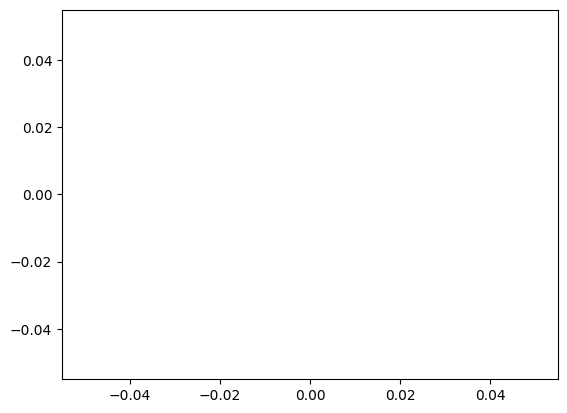

In [ ]:
sns.histplot(df['charges'], kde=True)
plt.title('Distribution of Insurance Charges')
plt.show()

The target variable (charges) is right-skewed. This suggests that a log transformation might help normalize the distribution, which can improve model performance.

### 3.2: Correlation Between Numerical Features

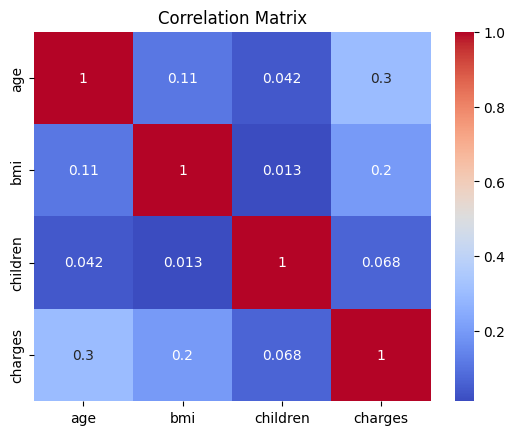

In [32]:
# Select only numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numerical_columns.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

We use Pearson correlation because it measures the linear relationship between two continuous variables. It’s appropriate here since age, bmi, and children are numerical features. A correlation close to 1 or -1 indicates a strong relationship, while 0 indicates no relationship.

Age and Charge are a moderate positive correlation. It suggests that as age increases, insurance charges tend to increase.

### 3.3 Categorical Feature Analysis

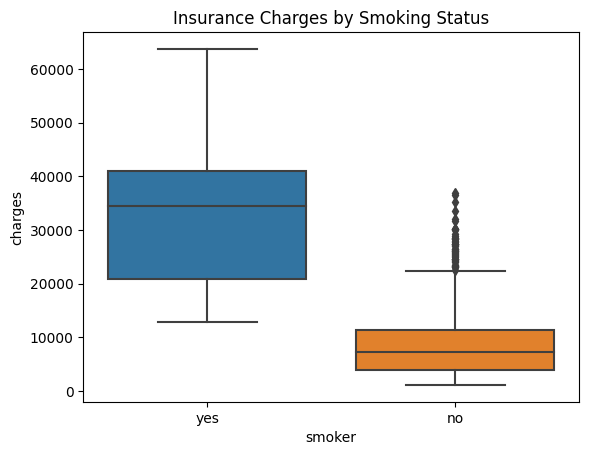

In [33]:
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Insurance Charges by Smoking Status')
plt.show()

Smokers tend to have higher insurance charges. This suggests that the smoker feature will be important in our model.

## 4. Data Preprocessing

### 4.1: Log Transformation of Target Variable

In [34]:
# Apply log transformation to the target variable
df['log_charges'] = np.log1p(df['charges'])

The log transformation is applied to address the right skewness of the target variable (charges). This transformation helps normalize the distribution, making it more suitable for regression models.

### 4.2 Pipelining

In [35]:
# Define numerical and categorical features
numerical_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())  # Scale numerical features
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(drop='first'))  # One-hot encode categorical features
        ]), categorical_features)
    ])

- Numerical Features: We use StandardScaler to standardize age, bmi, and children so that they have a mean of 0 and a standard deviation of 1. This ensures that all features contribute equally to the model.
- Categorical Features: We use OneHotEncoder to convert categorical variables (sex, smoker, region) into binary columns. The drop='first' parameter avoids multicollinearity by dropping the first category.

### 4.3 Split Data 

In [36]:
X = df.drop(['charges', 'log_charges'], axis=1)  # Features
y = df['log_charges']  # Target (log-transformed charges)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Modeling

### 5.1 Linear Regression
Linear regression is a simple and interpretable model. It assumes a linear relationship between features and the target, making it a good baseline.

In [38]:
X_train.head()

,age,sex,bmi,children,smoker,region
560,46,female,19.95,2,no,northwest
1285,47,female,24.32,0,no,northeast
1142,52,female,24.86,0,no,southeast
969,39,female,34.32,5,no,southeast
486,54,female,21.47,3,no,northwest


In [39]:
# Create a pipeline with preprocessing and linear regression
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
linear_pipeline.fit(X_train, y_train)

# Predict on test data
y_pred = linear_pipeline.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Linear Regression - MSE: {mse}, R2: {r2}')

Linear Regression - MSE: 0.17550910855320775, R2: 0.8047410791393018


### 5.2 Randomforest Regression
Random forests can capture non-linear relationships and interactions between features, often outperforming linear models. They are robust to overfitting and work well with mixed data types.

In [40]:
# Create a pipeline with preprocessing and random forest regression
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Fit the model
rf_pipeline.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest - MSE: {mse_rf}, R2: {r2_rf}')

Random Forest - MSE: 0.13639789209233824, R2: 0.8482534300517524


In [41]:
print(f'Linear Regression - MSE: {mse}, R2: {r2}')
print(f'Random Forest - MSE: {mse_rf}, R2: {r2_rf}')

Linear Regression - MSE: 0.17550910855320775, R2: 0.8047410791393018
Random Forest - MSE: 0.13639789209233824, R2: 0.8482534300517524


We compare the models using:

- Mean Squared Error (MSE): Measures the average squared difference between predicted and actual values. Lower MSE indicates better performance.
- R-squared (R2): Represents the proportion of variance in the target variable explained by the model. Higher R2 indicates better performance.

**The Random Forest** model has a **lower MSE (0.13)** and **a higher R2 (0.84)**, indicating better performance compared to Linear Regression.

QMl Modulus

      age     bmi  children
0      19  27.900         0
1      18  33.770         1
2      28  33.000         3
3      33  22.705         0
4      32  28.880         0
...   ...     ...       ...
1333   50  30.970         3
1334   18  31.920         0
1335   18  36.850         0
1336   21  25.800         0
1337   61  29.070         0

[1338 rows x 3 columns]
 Explained Variance Ratio: [0.37399127 0.33047988 0.29552885]
 Cumulative Explained Variance: [0.37399127 0.70447115 1.        ]


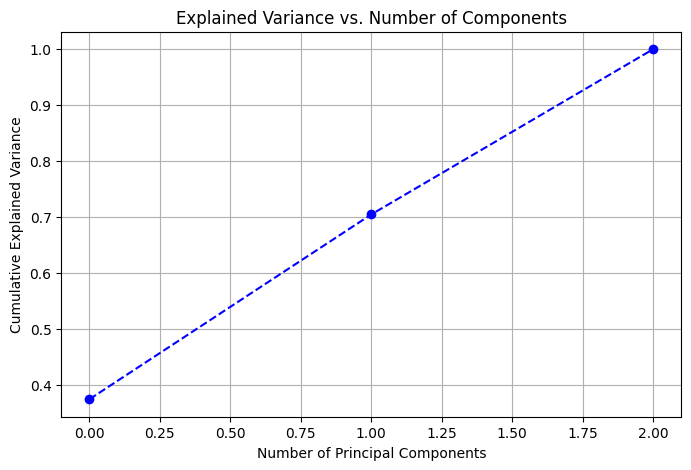


 PCA Transformed Data (First 5 Rows):
        PC1       PC2       PC3
0 -1.572298 -0.568520 -0.552977
1 -0.736864 -0.132435 -1.409044
2  0.186625  1.400318 -1.134575
3 -1.438374 -0.346120  0.732522
4 -0.826879 -0.700535  0.003378


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Step 1: Load the dataset with error handling
try:
    df = pd.read_csv("insurance.csv")  # Ensure file exists
except FileNotFoundError:
    print(" Error: The file 'insurance.csv' was not found. Please check the file path.")
    exit()

# Step 2: Select numerical features for PCA (excluding categorical 'HvarType')
features = ["age", "bmi", "children"]

# Check if features exist in dataset
missing_features = [f for f in features if f not in df.columns]
if missing_features:
    print(f"Error: Missing columns in dataset: {missing_features}")
    exit()

df_selected = df[features].dropna()  # Remove rows with missing values
print(df_selected)
# Step 3: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)

# Step 4: Apply PCA
num_features = X_scaled.shape[1]
pca = PCA(n_components=num_features)  # Keep all components initially
X_pca = pca.fit_transform(X_scaled)

# Step 5: Check Explained Variance
explained_variance = pca.explained_variance_ratio_

# Print explained variance of each component
print(" Explained Variance Ratio:", explained_variance)
print(" Cumulative Explained Variance:", np.cumsum(explained_variance))

# Step 6: Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# Step 7: Reduce to optimal number of components (keeping ~95% variance)
optimal_components = np.argmax(np.cumsum(explained_variance) >= 0.95) + 1
pca_reduced = PCA(n_components=optimal_components)
X_pca_reduced = pca_reduced.fit_transform(X_scaled)

# Step 8: Convert to DataFrame
df_pca = pd.DataFrame(X_pca_reduced, columns=[f'PC{i+1}' for i in range(optimal_components)])

#  Fix: Replace ace_tools with a standard Pandas display
print("\n PCA Transformed Data (First 5 Rows):")
print(df_pca.head())  # Show first few rows of PCA-transformed data

In [66]:
from sklearn.decomposition import KernelPCA

X_train_filtered = X_train[["age", "bmi", "children"]]
X_test_filtered = X_test[["age", "bmi", "children"]]
print(y_train)

#complete the code
kernel_PCA_RBF = KernelPCA(n_components=2,kernel="rbf")
kernel_PCA_RBF.fit(X_train_filtered)


560      9.126398
1285     9.052009
1142    10.207990
969      9.059265
486      9.431590
          ...    
1095     8.425558
1130     9.057574
1294     9.386990
860     10.738883
1126     9.231675
Name: log_charges, Length: 1070, dtype: float64


KernelPCA(kernel='rbf', n_components=2)

In [67]:
train_features_RBF = kernel_PCA_RBF.fit_transform(X_train_filtered)
test_features_RBF = kernel_PCA_RBF.fit_transform(X_test_filtered)


In [68]:
train_features_RBF.shape, y_train.shape, test_features_RBF.shape

((1070, 2), (1070,), (268, 2))

In [69]:
# Create a pipeline with preprocessing and linear regression
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
linear_pipeline.fit(train_features_RBF, y_train)

# Predict on test data
y_pred = linear_pipeline.predict(test_features_RBF)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Linear Regression - MSE: {mse}, R2: {r2}')

ValueError: Specifying the columns using strings is only supported for dataframes.

In [70]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(train_features_RBF, y_train)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.